# Politica Gaussiana

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import math

SEED = 42

torch.manual_seed(SEED)

def normal(x, mu, sigma_sq):
    a = (-1*(x-mu).pow(2)/(2*sigma_sq)).exp()
    b = 1/(2*sigma_sq*math.pi).sqrt()
    return a*b

class GaussianPolicy(nn.Module):
    def __init__(self, n_users: int, d_R: int, hidden_dimension: int):
        '''
        Params:
            - n_users: número de usuários
            - d_R: dimensão da representação dos usuários
            - hidden_dimension: número de neurôneos na camada oculta
        '''
        super().__init__()
        
        self.n_users = n_users
        self.d_R = d_R
        self.hidden_dimension = hidden_dimension

        self.one_hot = F.one_hot
        
        self.linear1 = nn.Linear(n_users, hidden_dimension)
        self.linear_mu = nn.Linear(hidden_dimension, d_R)
        self.linear_sigma = nn.Linear(hidden_dimension, d_R)

    def forward(self, xb):
        xb = self.one_hot(xb, num_classes=self.n_users).to(torch.float32)
        xb = F.relu(self.linear1(xb))
        mu = self.linear_mu(xb)
        sigma_sq = self.linear_sigma(xb)
        return mu, sigma_sq
    
    def act(self, xb):
        # Batch of users
        mu, sigma_sq = self.forward(xb)
        sigma_sq = F.softplus(sigma_sq)
        eps = torch.randn(mu.size())
        action = (mu + sigma_sq.sqrt()*eps).data
        log_prob = normal(action, mu, sigma_sq).log()
        return action, log_prob

# Recommender Model

In [3]:
from src.nrms import NRMS

recommender_model = NRMS(model_path='./nrms_data/model/nrms_ckpt')

2022-12-11 21:23:20.858787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 21:23:21.669669: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-11 21:23:21.669718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-11 21:23:21.669725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# CPR

In [4]:
import pandas as pd
import os
from os.path import join

from src.pr_model import P_R_Network
from src.ps_model import P_S_Network

In [5]:
class CPR:
    def __init__(self, pr_model, ps_model, n_items):
        self.pr_model = pr_model
        self.Q = pr_model.item_emb.weight.data
        self.wR = pr_model.w.data.squeeze()
        
        self.ps_model = ps_model
        self.n_items = n_items
    
    def sample_alpha_posterior(self):
        return torch.randn(self.n_items)
    
    def sample_beta_posterior(self, k):
        return torch.randn(k)
    
    def gen_r_from_tau(self, tau, k):
        """
        tau: action center - torch.tensor(1, emb_dim)
        k: number of items - int
        """
        alpha = self.sample_alpha_posterior()
        score = (tau @ self.Q.T) + (self.wR * alpha)

        scores_dict = dict(enumerate(score[0]))
        sorted_dict = dict(sorted(scores_dict.items(), key=lambda item:item[1], reverse=True))

        return list(sorted_dict.keys())[:k]

    def gen_s(self, u, r, M):
        """
        u: user id - int
        r: list of item ids - [int]
        M - itens to be selected - int
        """
        beta = self.sample_beta_posterior(len(r))
        
        u_b = torch.LongTensor([[u]])
        r_b = torch.LongTensor([r])
        r_mask_b = torch.ones(1, len(r))
        beta_b = beta.unsqueeze(0)
        score = self.ps_model(u_b, r_b, r_mask_b, None, beta_b).data[0]
        
        scores_dict = dict(zip(r, score))
        sorted_dict = dict(sorted(scores_dict.items(), key=lambda item:item[1], reverse=True))
        return list(sorted_dict.keys())[:M]

# Carregando dados

In [6]:
data_path = ''

user_df = pd.read_csv(join(data_path, 'user_d.csv'))
user_d = {code: ind for code, ind in zip(user_df['code'], user_df['indice'])}
user_idx_to_code = {ind: code for code, ind in zip(user_df['code'], user_df['indice'])}

item_df = pd.read_csv(join(data_path, 'item_d.csv'))
item_d = {code: ind for code, ind in zip(item_df['code'], item_df['indice'])}
item_idx_to_code = {ind: code for code, ind in zip(item_df['code'], item_df['indice'])}

In [7]:
pr_model = P_R_Network(len(user_d)+1, len(item_d)+1, emb_dim=2)
pr_model.load_state_dict(torch.load('pr_model.pth'))

<All keys matched successfully>

In [8]:
ps_model = P_S_Network(len(user_d)+1, len(item_d)+1, 299, emb_dim=2)
ps_model.load_state_dict(torch.load('ps_model.pth'))

<All keys matched successfully>

In [9]:
cpr = CPR(pr_model, ps_model, len(item_d)+1)

# Treinar Gaussiana


In [10]:
rewards = list()

class CPR_Env:
    def __init__(self, cpr, recommender, k, M):
        self.cpr = cpr
        self.recommender = recommender
        self.k = k
        self.M = M
        
    def compute_reward(self, action, u):
        """
        Recebe um batch de acoes e devolve um batch de recompensas
        action: torch.tensor(batch_sz, emb_dim)
        u: torch.tensor(batch_sz)
        reward: torch.tensor(batch_sz)
        """
        batch_sz = action.size(0)
        reward = torch.zeros(batch_sz)
        for i in range(batch_sz):
            u_id = u[i].item()
            tau = action[i].unsqueeze(0)
            
            r = self.cpr.gen_r_from_tau(tau, self.k)
            s = self.cpr.gen_s(u_id, r, self.M)

            r = [item_idx_to_code[r_] for r_ in r]
            s = [item_idx_to_code[s_] for s_ in s]
            u_code = user_idx_to_code[u_id]
            
            reward[i] = self.recommender.calculate_loss(u_code, r, s)
            print(f'u: {u_code} \n\tr: {r} \n\ts: {s}\n\treward: {reward[i]}')

            rewards.append(reward[i])
        
        return reward

In [11]:
def reinforce_batch(policy, optimizer, u, env):
    action, log_prob = policy.act(u)
    reward = env.compute_reward(action, u)
    loss = -(log_prob * reward.unsqueeze(1)).sum() #Ideia: torch.ones(3,4) * torch.tensor([1,2,3]).unsqueeze(1)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [12]:
env = CPR_Env(cpr, recommender_model, 5, 2) # alterar para colocar o recomendador para calcular loss

In [15]:
policy = GaussianPolicy(len(user_d)+1, 2, 16)
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)
batch_size = 16

In [16]:
# Loop de treinamento => tem que corrgir para colocar a loss do recomendador
for ep_i in range(100):
    u = torch.randint(1, len(user_d)+1, (batch_size,))
    reinforce_batch(policy, optimizer, u, env)

/home/elves/WorkSpaces/Personal/CPR_Code/venv/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/elves/WorkSpaces/Personal/CPR_Code/venv/lib/python3.7/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-12-11 21:26:00.144530: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:2002 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/activation_loss/value)}}' was changed by setting attrib

u: U12914 
	r: ['N28422', 'N45209', 'N46921', 'N24110', 'N53998'] 
	s: ['N46921', 'N28422']
	reward: 2.264436960220337
u: U87785 
	r: ['N46071', 'N31943', 'N35839', 'N17477', 'N59356'] 
	s: ['N46071', 'N35839']
	reward: 0.7509019374847412
u: U57071 
	r: ['N12009', 'N17841', 'N42605', 'N58546', 'N28804'] 
	s: ['N58546', 'N42605']
	reward: 1.6227171421051025
u: U48836 
	r: ['N20051', 'N21064', 'N8849', 'N58610', 'N35125'] 
	s: ['N58610', 'N21064']
	reward: 1.15378737449646
u: U85889 
	r: ['N42605', 'N61836', 'N36718', 'N45940', 'N51600'] 
	s: ['N51600', 'N36718']
	reward: 2.066023111343384
u: U73036 
	r: ['N7635', 'N28422', 'N48588', 'N42083', 'N15780'] 
	s: ['N42083', 'N28422']
	reward: 2.0674185752868652
u: U17373 
	r: ['N24878', 'N37989', 'N44907', 'N46720', 'N53508'] 
	s: ['N44907', 'N53508']
	reward: 1.9588757753372192
u: U32781 
	r: ['N18251', 'N46079', 'N61839', 'N6494', 'N48588'] 
	s: ['N6494', 'N61839']
	reward: 1.172008752822876
u: U63624 
	r: ['N57813', 'N26309', 'N14637', 'N5

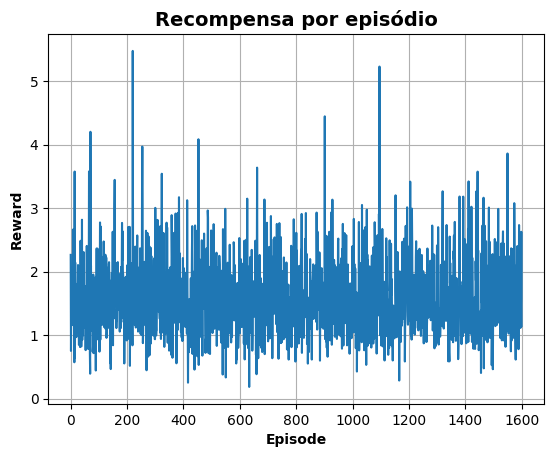

In [26]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()

xs = list(range(len(rewards)))

ax.plot(xs, rewards)
# ax.set_ylim(1, 0)

ax.set_ylabel('Reward', 
              fontweight ='bold')


ax.set_xlabel('Episode', 
              fontweight ='bold')

ax.grid(True)
   
ax.set_title('Recompensa por episódio', fontsize = 14, fontweight ='bold')
plt.show()

# plt.plot(rewards)

# Gera novos training samples

In [27]:
behaviors_col_names = ['ImpressionID', 'UserID', 'Time', 'History', 'Impressions']

base_behavior = pd.read_table('./nrms_data/train/behaviors.tsv', header=None, names=behaviors_col_names)

In [28]:
base_behavior

,ImpressionID,UserID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...
...,...,...,...,...,...
156960,156961,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...
156961,156962,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...
156962,156963,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...
156963,156964,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...


In [71]:
from tqdm import tqdm
import random 

random.seed(42)

data = list()

users = list(user_d.values())[:10000] 
behavior_id = base_behavior.index.stop + 1

try:
    for i in tqdm(range(0, len(users) + 1, batch_size)):
        u = torch.as_tensor(users[i:i+batch_size])

        taus, _ = policy.act(u)

        for i in range(len(u)):
            k = random.randint(1, 10)
            M = random.randint(0, k)

            u_id = u[i].item()
            tau = taus[i].unsqueeze(0)
            
            r = cpr.gen_r_from_tau(tau, k)
            s = cpr.gen_s(u_id, r, M) if M > 0 else []

            r = [item_idx_to_code[r_] for r_ in r]
            s = [item_idx_to_code[s_] for s_ in s]

            u_code = user_idx_to_code[u_id]

            counterfactual_impression = ' '.join(list(map(lambda x: f'{x}-{1 if x in s else 0}', r)))

            # print(type(base_behavior[base_behavior.UserID == u_code]))

            # counterfactual_behavior.Impressions = counterfactual_behavior.Impressions.apply(lambda x: counterfactual_impression) 
            for _, row in base_behavior[base_behavior.UserID == u_code].iterrows():
                data.append((behavior_id, row.UserID, row.Time, row.History, counterfactual_impression ))
                behavior_id +=1
except:
    pass 

counterfactual_behaviors = pd.DataFrame(data, columns=['ImpressionID', 'UserID', 'Time', 'History', 'Impressions'])

100%|█████████▉| 625/626 [2:15:22<00:12, 13.00s/it]  


In [73]:
counterfactual_behaviors.to_csv('counterfactual_behaviors.tsv', sep='\t', index=False, header=False)

In [72]:
counterfactual_behaviors

,ImpressionID,UserID,Time,History,Impressions
0,156966,U32426,11/14/2019 11:00:18 AM,N1150 N55846 N13008 N59546 N18030 N46392 N5809...,N9506-0 N27838-0
1,156967,U21312,11/9/2019 3:08:20 AM,N38747 N62451 N39376 N46597,N39720-0 N36448-0 N9620-0 N53748-1 N62797-0
2,156968,U21312,11/11/2019 6:38:48 AM,N38747 N62451 N39376 N46597,N39720-0 N36448-0 N9620-0 N53748-1 N62797-0
3,156969,U93847,11/11/2019 5:52:59 AM,N61826 N39993 N58226 N55920 N1267 N35129 N2753...,N35427-0 N38515-0 N57813-1 N44352-0
4,156970,U93847,11/14/2019 6:13:29 AM,N61826 N39993 N58226 N55920 N1267 N35129 N2753...,N35427-0 N38515-0 N57813-1 N44352-0
...,...,...,...,...,...
32358,189324,U14379,11/12/2019 10:21:40 AM,N1569 N11071 N15254 N27448 N52677 N65066 N5518...,N18251-1 N33600-0 N16026-1 N35125-1 N48295-0 N...
32359,189325,U14379,11/12/2019 10:59:20 AM,N1569 N11071 N15254 N27448 N52677 N65066 N5518...,N18251-1 N33600-0 N16026-1 N35125-1 N48295-0 N...
32360,189326,U14379,11/11/2019 5:22:34 AM,N1569 N11071 N15254 N27448 N52677 N65066 N5518...,N18251-1 N33600-0 N16026-1 N35125-1 N48295-0 N...
32361,189327,U14379,11/12/2019 6:26:31 AM,N1569 N11071 N15254 N27448 N52677 N65066 N5518...,N18251-1 N33600-0 N16026-1 N35125-1 N48295-0 N...
